Solve:
$$\Delta u = f \quad \text{on} \; \Omega$$
$$ u = g \quad \text{on} \;\Gamma$$
Steps:
- Define a kernel function
- define differentiated kernel function
- Generate inside center points
- Generate boundary center points
- generate function f on $\Omega$
- generate function g on $\Gamma$
- generate centers for Partition of unity 
- generate kd tree for all data points(internal + boundary)
- generate sparce matrix with shepard weights for each location 
- for each patch:
    - create Kernel matrix $\Phi$ of all points in that partch 
    - create polynomial matrix P for all points in the 
    - assemble the local system
    - invert local sustem, and get $U^*$
    - multiply entries by $w_l$ and add to the corresponding positions in the global matrix
- assemble RHS
- solve sparse system 
$$
\begin{aligned}
\nabla^2 u(x, y) & =-\frac{5}{4} \pi^2 \sin (\pi x) \cos \left(\frac{\pi y}{2}\right), \quad(x, y) \in \Omega=[0,1]^2 \\
u(x, y) & =\sin (\pi x), \quad(x, y) \in \Gamma_1 \\
u(x, y) & =0, \quad(x, y) \in \Gamma_2
\end{aligned}
$$

where 
$ \Gamma_1= \{(x, y): 0 \leq x \leq 1, y=0\} \; \text{and} \; \Gamma_2=\partial \Omega \backslash \Gamma_1 $. 
As can easily be verified, the exact solution is given by
$$u(x, y)=\sin(\pi x) \cos \left(\frac{\pi y}{2}\right) $$


In [1]:
include("RBFunctions.jl")
using GeometryBasics
using Plots 

In [2]:
function polyharmonic_4(r,ϵ)
    if r < 1e-50
        return 0.0
    else
        return (r^4)*log(r)
    end
end

function Δpolyharmonic_4(r,ϵ)
    if r < 1e-50
        return 0.0
    else
        return 16*r*r*log(r) + 8*r*r
    end
end

function f(x,y)
   return -5/4 * π*π * sin(π*x) * cos(π*y/2)
end

function g1(x,y)
    return sin(π*x)
end

function g2(x,y)
    return 0
end

function exact_solution(x,y)
    return sin(π*x)*cos(π*y/2)
end
Δpolyharmonic_4(1.0,0)

8.0

In [3]:
N_i= 100 # number of interiror points 
N_b = 20 # number of boundary points on all sides 
N = N_i + N_b*4
N_pu = 4 # number of partition regions
radius = 1/(N_pu-1) # radius of partiton region 

0.3333333333333333

In [4]:
# generate list of interiror points 
p_list = generate_2D_Halton_points(N_i)
p_list = Point.(p_list[1,:],  p_list[2,:]) 
interiror_points = []
for i in 1:N_i
    p = p_list[i]
    meta_point = PointMeta(p, index = i, operator = Δgaussian, value = f(p[1],p[2]))
    append!(interiror_points,[meta_point])
end

# generate list of boundary points 
a = LinRange(0,1-1/(N_b-1),N_b)
b = zeros(N_b)
c = ones(N_b)
bp1_list = Point.(a,b) 
bp2_list= append!(Point.(c,a),Point.((a.+1/(N_b-1)),c),Point.(b,(a.+1/(N_b-1))))
boundary_points = []
for i in 1:N_b
    p = bp1_list[i]
    meta_point = PointMeta(p, index = N_i+i, operator = gaussian, value = g1(p[1],p[2]))
    append!(boundary_points,[meta_point])
end
for i in 1:N_b*3
    p = bp2_list[i]
    meta_point = PointMeta(p, index = N_i+N_b+i, operator = gaussian, value = g2(p[1],p[2]))
    append!(boundary_points,[meta_point])
end
#a = metafree.(boundary_points)
# generate PU centers 
points = vcat(interiror_points,boundary_points)
pp = collect(LinRange(0,1,N_pu))
pu_sites = hcat(vec(ones(N_pu) * pp'),vec(pp * ones(N_pu)'))'
typeof(p_list)

Vector{Point2{Float64}} (alias for Array{Point{2, Float64}, 1})

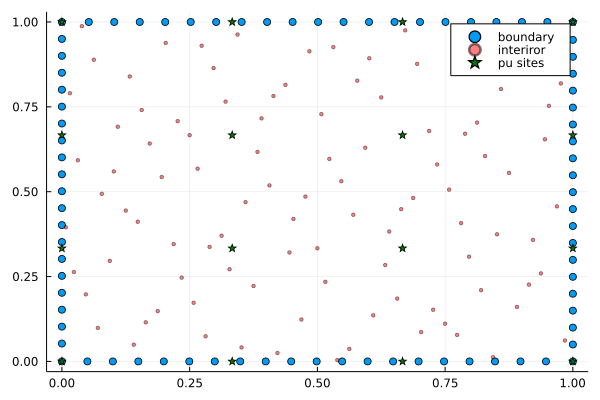

In [5]:
scatter([boundary_points[i][1] for i in 1:N_b*4], 
[boundary_points[i][2] for i in 1:N_b*4],label = "boundary ")
scatter!([interiror_points[i][1] for i in 1:N_i], 
[interiror_points[i][2] for i in 1:N_i], label="interiror", mc=:red, ms=2, ma=0.5)
scatter!(pu_sites[1,:] ,pu_sites[2,:] , label="pu sites", mc=:green, markershape =:star)

In [6]:
using TypedPolynomials
function Poly_functions_vec(deg,d_x,d_y)
    dim = 2 # number of dimensions
    Q = factorial(deg+dim-1)÷(factorial(dim)*factorial(deg-1))
    @polyvar x y
    T = Polynomial{Int64, Term{Int64, Monomial{(x, y), 2}}, Vector{Term{Int64, Monomial{(x, y), 2}}}}
    p_vec = Array{T,1}(undef, Q)
    counter = 1
    for i in 0:(deg-1)
        for j in 0:i
            p_vec[counter] = differentiate(differentiate(x^(i-j)*y^j, x, Val{d_x}()),y,Val{d_y}())
            counter+=1
        end
    end
    return p_vec
end

function ΔPoly_functions_vec(deg) #Laplacian operator for polynomials
    # returns a vector of functions 
    Δₓp = Poly_functions_vec(deg,2,0)
    Δᵥp = Poly_functions_vec(deg,0,2)
    return Δₓp+Δᵥp
end

function poly_evaluate(pol_list,a,b)
    @polyvar x y
    return [pol_list[i](x=>a,y=>b) for i in 1:length(pol_list)]
end
function Polynom_matrix(x_list,y_list,deg)
    n = length(x_list)
    dim = 2 # number of dimensions 
    Q = factorial(deg+dim-1)÷(factorial(dim)*factorial(deg-1))
    P = zeros(n,Q)
    P[:,1] = ones(n)
    counter = 1
    for i in 1:(deg-1)
        for j in 0:i
            counter+=1
            P[:,counter] = x_list.^(i-j) .* y_list.^j
        end
    end
    return Q,P
end

Poly_functions_vec(2,0,0)

3-element Vector{Polynomial{Int64, Term{Int64, Monomial{(x, y), 2}}, Vector{Term{Int64, Monomial{(x, y), 2}}}}}:
 1
 x
 y

In [7]:
# create list with all collocation points 
ϵ = 3
poly_degree = 3
pure_points = metafree.(points) # list of points without metadata(this is compatible with other packages)
points_x = [pure_points[i][1] for i in 1:N]
points_y = [pure_points[i][2] for i in 1:N]
# create k-d tree for all points 
KD_tree = KDTree(pure_points,Euclidean(),leafsize = 3)
#create polynamoal and differentiated polynomial function vector 
poly = Poly_functions_vec(poly_degree,0,0)
Δpoly = ΔPoly_functions_vec(poly_degree)
# create empty sparce sparce matrix N by N 
A = spzeros(N,N)
Shepard_matrix = spzeros(N,N_pu^2)
max_cond_M = 1.0
max_cond_U = 1.0
for i in 1:N_pu^2
    # find all points that lie within iᵗʰ patch
    idxs_data = inrange(KD_tree, pu_sites[:,i], radius, true)
    p_x = points_x[idxs_data]
    p_y = points_y[idxs_data]
    # construct local phi Φ
    Dist_matrix = pairwise(Euclidean(), pure_points[idxs_data], pure_points[idxs_data])
    Φ = polyharmonic_4.(Dist_matrix,ϵ)
    # construct polynomial matrix P
    Q,P = Polynom_matrix(p_x,p_y,poly_degree)
    # combine these and invert
    M = vcat(hcat(Φ,P),hcat(P',zeros((Q,Q))))
    if cond(M)> max_cond_M
        max_cond_M = cond(M)
    end
    print(cond(M)," ")
    M_inv = inv(M)
    
    inter_indexs = filter(x -> x <=N_i, idxs_data) # indexes to which apply laplace operator
    n_interiror = length(inter_indexs)
    n_boundary = length(idxs_data) - n_interiror
    R1 = Δpolyharmonic_4.(Dist_matrix[:,1:n_interiror],ϵ)
    S1 = hcat(poly_evaluate.((Δpoly,),points_x[inter_indexs],points_y[inter_indexs])...)
    boundary_indexs = filter(x -> x >N_i, idxs_data) # indexes to which apply Boundary operator
    #println(poly_evaluate.((poly,),points_x[boundary_indexs],points_y[boundary_indexs]))
    if n_boundary==0 
        RS = vcat(R1,S1)
    else
        R2 = polyharmonic_4.(Dist_matrix[:,n_interiror+1:end],ϵ)
        S2 = hcat(poly_evaluate.((poly,),points_x[boundary_indexs],points_y[boundary_indexs])...)
        RS = hcat(vcat(R1,S1),vcat(R2,S2))
    end
    #display(R1)
    #display(M)
    # Now the weight functions:
    
    U = (M_inv * RS)[1:end-Q,:]
    #println(maximum(abs.(M)))

    if cond(U)> max_cond_U
        max_cond_U = cond(U)
    end
    #print(cond(U),"  ")
     
    PU_weights = wendland_C2.(pairwise(Euclidean(), pure_points[idxs_data], [pu_sites[:,i]]),radius)
    #display(PU_weights)
    A[idxs_data,idxs_data] += U' .* PU_weights
    Shepard_matrix[idxs_data,i] = PU_weights
end

sdsd = sum(Shepard_matrix, dims=2).^-1
A = A .* sdsd # multiply by pu weigths 
# Assemble rhs
RHS = [points[i].value for i in 1:N]
#for i in 1:N
#    println(sum(abs.(Matrix(A)[i,:])))
#end
uu = A\RHS

println("max cond U ",max_cond_U)
println("max cond M ",max_cond_M)
#println("max cond A ",cond(Matrix(A)))
#println("cond A ",cond(Matrix(A)))
println(maximum(Matrix(A[31:end,1:30])))
println(maximum(Matrix(A[31:end,31:end])))
#display(round.(Matrix(A)[31:end,31:end],digits=2))
display(A)
evals = eigvals(Matrix(A)[1:100,1:100])

1.1746861919395933e6 3.861045853542155e6 2.50765137217683e6 4.202037095291744e6 1.5719177940687478e7 704459.8325118367 696959.9709677496 2.9294641087483116e6 1.9710315572727267e7 804270.9964619355 725317.7192213674 3.0452089196333583e6 2.8856818096732246e6 2.7909040520378975e6 3.176088659887286e6 2.243885941541183e6 max cond U 7.440977281265992e19
max cond M 1.9710315572727267e7
1508.1550821588148
6074.294041388838


180×180 SparseMatrixCSC{Float64, Int64} with 9963 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⡧⠴⠶⠖⢒⣒⣂⣀⣀⣀⣤⣤⠤⠔⢚⣛⣛⣛
⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⠛⠛⠯⠭⠤⠭⠭⠉⣤⣭⣭⣭⣝⣛⣛⣃⣠
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣯⣿⣟⣿⣿⣿⣟⡯⢽⣛⣓⣚⣉⡭⠭⠤⣉⣭⣭⣤⡬⠭⠭⠍⢉
⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⣿⣿⣷⣿⣿⣿⣷⣷⣶⣶⡶⠶⠒⣛⣛⣛⠤⣍⣉⣉⣉⣩⣭⣥⣤
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣿⣿⡧⢴⣶⣖⣒⣒⣒⣒⣀⣭⣭⣭⠤⠔⠒⠒⣒⣺
⣿⣿⣿⣿⣿⣻⣻⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣧⣿⣿⣿⣿⣗⣒⣀⣀⣠⠤⠭⢭⣉⠤⣤⣤⣉⡑⢒⣒⣦⣤
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⡷⢶⣶⣖⣚⣉⣭⣭⠭⣉⣥⣤⣤⡤⠬⠭⠍⢉
⢿⣿⣿⣿⡿⣿⣿⣿⢿⣿⣿⢿⣿⣿⣿⢟⢿⣿⣿⣿⣿⡿⣗⣲⣶⡦⠴⠒⣒⣒⣒⠭⣭⣭⣉⣙⣻⣿⡯⠭
⣿⣿⣿⣿⣿⢿⢿⣿⣿⣿⠿⣿⣿⣿⣿⣷⣿⢟⢿⣿⣿⢿⣇⣐⣒⣒⣲⠶⠶⠶⠤⣉⣭⣭⠤⠔⢒⣒⣒⣚
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣷⣿⣿⣿⣿⣗⣒⣒⣦⣤⠤⠭⠭⠉⣤⣤⣤⣀⡸⠿⠿⠧⢤
⣿⣿⣿⣿⣿⢿⢿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣟⣿⣿⣿⣿⡧⢴⣒⣒⣚⣛⡛⠛⠛⣉⣉⣉⠒⠢⠬⠭⣍⣉
⢉⡏⣿⠉⣏⣏⢹⣿⢉⣏⢹⢹⢹⣏⢹⣹⢉⢹⢹⢹⢉⣏⣿⣿⣶⣆⣀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⠉⠉⠉
⢸⠇⡿⡄⢿⢸⢸⡿⢸⢿⠀⢸⢸⢿⠸⡿⢸⢸⠸⣼⢸⢸⠿⢿⣿⣿⣿⣤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⢰⠃⡇⡞⢸⢸⠃⢸⢸⠀⡞⡞⢸⢰⠃⢸⡞⠀⡟⣾⢸⠀⠘⠛⣿⣿⣿⣷⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⢸⡇⡇⡇⡏⣿⢸⢸⢸⡇⣇⡇⣿⢸⢸⢸⡇⡇⡇⣿⠀⠀⠀⠀⠉⢹⣿⣿⣿⣿⠀⠀⠀⣀⡀⠀⠀⠀⠀
⠀⢸⠃⣤⡄⢣⠛⡜⡄⣼⠃⡜⡇⢣⡜⡜⡄⢣⠃⣤⡟⢠⠀⠀⠀⠀⠀⠀⠛⠛⠛⣤⣤⣤⠛⠃⠀⠀⣤⣤
⠀⣿⡇⣿⡇⣿⡇⢹⡇⣿⠀⣿⠁⣿⡇⣿⡇⣿⠀⣿⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⡇⠀⠀⠉⢹
⢀⠇⣇⢿⡀⡿⡇⢸⢀⠇⢇⠸⠀⡿⣇⢸⢀⠇⣀⡸⠸⡀⣀⣀⠀⠀⠀⠀⠀⠸⠿⠀⠿⠿⠿⢇⣀⣀⡀⠀
⣾⢰⣿⢸⡇⡇⡇⣾⢸⠀⢸⢰⡆⡇⣿⣾⢸⢰⣿⡇⡆⡇⡟⠛⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣷⣶
⣿⢸⠉⢸⡇⠁⠁⣿⢸⢸⠈⣿⡇⠁⡏⡏⢸⢸⠉⡇⡇⢹⡇⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⠀⠈⢹⣿⣿⣿

100-element Vector{ComplexF64}:
   -9160.16292900975 + 0.0im
  -3807.467319544911 + 0.0im
  -3721.187877580146 + 0.0im
 -2839.1479837273073 + 0.0im
  -2821.958927372426 + 0.0im
 -2800.5738135550937 + 0.0im
 -2619.8951999739465 - 94.93483910636259im
 -2619.8951999739465 + 94.93483910636259im
  -2592.858284606015 + 0.0im
   -2495.15121005396 + 0.0im
  -2420.795087629855 + 0.0im
 -2403.6771406362095 + 0.0im
 -2358.0986056626953 + 0.0im
                     ⋮
 -204.71289327133917 + 0.0im
 -186.69809158653564 + 0.0im
 -174.71781616435374 - 0.46154907576561377im
 -174.71781616435374 + 0.46154907576561377im
  -132.7042490085573 + 0.0im
  -131.6772101493854 + 0.0im
 -101.04577611554681 + 0.0im
 -100.76888108108079 + 0.0im
  -79.78070693497145 + 0.0im
   -49.9246424952962 - 0.08857821016744427im
   -49.9246424952962 + 0.08857821016744427im
 -19.816026069988084 + 0.0im

In [8]:
print(maximum(real.(evals)))
print(real.(evals)[101:end])
maximum(A[1:100,101:end])

-19.816026069988084Float64[]

6074.294041388838

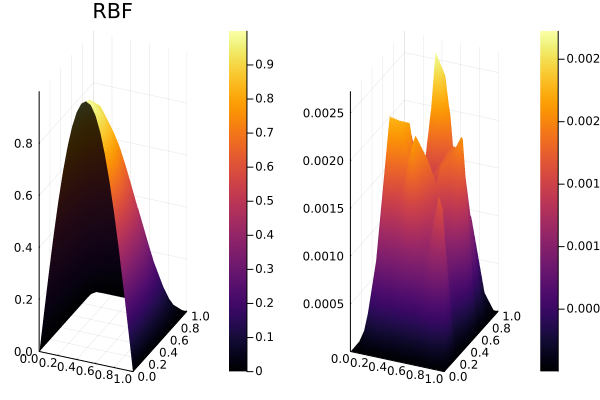

In [9]:
p1 = surface(points_x,points_y,uu,title = "RBF")
p2 = surface(points_x,points_y,abs.((uu .- exact_solution.(points_x,points_y))))
plot(p1,p2)

In [60]:
using DifferentialEquations
using BenchmarkTools
ν = 1.0
AA = spzeros(N,N)
AA[1:N_i,:] = ν*A[1:N_i,:] 
AA[N_i+1:end,:] = A[N_i+1:end,:]
AA = Matrix(AA) 
M = spzeros(N,N)
M[1:N_i,1:N_i] = sparse(I,N_i,N_i)
M = Matrix(M)
params = (AA,RHS)

function f1!(du,u,p,t) 
    A = p[1]
    RHS = p[2]
    du[:] .= A*u
    du[1:N_i] .+= -RHS[1:N_i]
    du[N_i+1:end] .+= cos(0.5*t) .* -RHS[N_i+1:end]
    #return du
end

function jac1!(u,p,t)
    return p[1]
end
tspan = (0.0, π*4)
ODEfunc = ODEFunction(f1!,mass_matrix = M)
#prob = ODEProblem(dae_func,uu,tspan,(AA,f,RHS)) ABDF2, Rodas3 linsolve = IterativeSolversJL_GMRES()
prob = ODEProblem(ODEfunc,uu,tspan,params,mass_matrix = M)
sol = solve(prob,ABDF2(linsolve = KrylovJL_GMRES()))


retcode: Success
Interpolation: 3rd order Hermite
t: 63-element Vector{Float64}:
  0.0
  1.0e-6
  2.0e-6
  1.1999999999999999e-5
  0.00011199999999999998
  0.0011119999999999997
  0.011111999999999997
  0.11111199999999996
  0.4852703793592458
  0.8881114253371265
  1.2948431638836393
  1.701574902430152
  2.109590538942405
  ⋮
  9.206235912373485
  9.518208311652637
  9.731930643551589
  9.94565297545054
 10.363609092140143
 10.632253226493788
 10.90089736084743
 11.541445204266202
 11.741470597699067
 11.941495991131932
 12.315715438055983
 12.566370614359172
u: 63-element Vector{Vector{Float64}}:
 [0.8638618016793035, 0.35233077010742025, 0.6954268240039362, 0.2915580012629415, 0.3141900751859159, 0.8667959861343812, 0.24390737425120068, 0.03320014054635067, 0.9788443714797931, 0.6924262065487876  …  2.1426037822331576e-14, 2.59903236450699e-14, 2.654521601677198e-14, 4.510474449474563e-14, 4.05416213737067e-14, 4.479989267423181e-14, 2.2139524796069417e-14, -9.53068240049067e-16, -

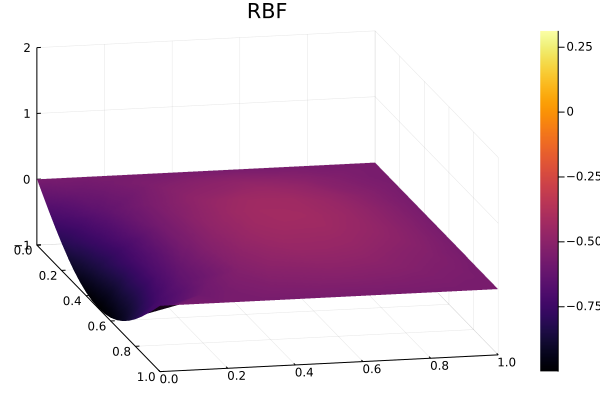

In [57]:
maximum(sol(0.0))
p1 = surface(points_x,points_y,sol(6.28),title = "RBF")
plot!(p1, camera = (70,50))

┌ Info: Saved animation to 
└   fn = "c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\tmp.gif"


Plots.AnimatedGif("c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\tmp.gif")
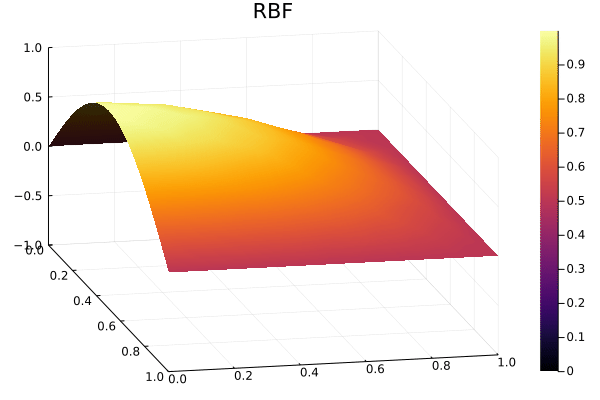

In [61]:
@gif for i ∈ LinRange(0.0,π*4,120)
    p1 = surface(points_x,points_y,sol(i),title = "RBF",zlims=(-1,1))
    plot(p1, camera = (70,50))
end 